In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue May 11 23:15:57 2021

@author: ellen degennaro

Purpose:
Generate histogram showing distribution of cells
throughout layers of cortex (laminar distribution)
for cells counted using FIJI software

Input:
    - csv with cell x and y locations and apical/basal surface locations
    - csv with animal info metadata (including blinded filenames)

Output:
    - new data structures containing all data, including normalized y positions
for all cells
    - histograms of laminar position by experimental condition
    
Updates:
5/12/21:
    - store complete dfs for easier plotting
5/16/21:
    - normalize number of cells to total per image (for X-axis)
    - save an output of summary stastistics (for collaborator)
8/12/22:
    - import and modify as jupyter notebook for better viewing on public github
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

In [2]:
{
    "tags": [
        "remove-cell"
    ]
}
root_directory = '/Users/ellendegenn/Dropbox (MIT)/Walsh Lab/KIF26A/Image Analysis/laminar_quantification/'

In [3]:
############
### load metadata csv
############
BaseDir = root_directory
OutDir = BaseDir+'210519_out/'
CellDir = BaseDir+'210501_210510_results/'
metafile = 'Master01.csv'

metadf = pd.read_csv(BaseDir+metafile)

In [4]:
############
### load csvs from folder
############

numfiles = len(metadf)

#initialize empty df to store all the data
fulldf = pd.DataFrame()

for current in range(0,numfiles):
    
    #cellfile = 'blind_0001.csv'
    cellfile = metadf['Blinded_Name'][current]+'.csv'

    #now can get cell data
    celldf = pd.read_csv(CellDir+cellfile)

    #let's get all the cells
    allx = celldf['X'][celldf['Counter']==0]
    ally = celldf['Y'][celldf['Counter']==0]

    #check lengths
    """
    if (len(allx)==(np.subtract(len(celldf),2))):
        print('X length ok')
    if (len(ally)==(np.subtract(len(celldf),2))):
        print('Y length ok')
    """

    #now check for the y-position of the apical and basal
    # tissue boundaries - won't know which is which yet
    ybounds = celldf['Y'][celldf['Counter']==1]
    #drop indices
    ybounds = ybounds.reset_index(drop=True)
    #then figure out which is bigger and assign
    
    #confirm that image coordinates are right-side up
    if np.subtract(ybounds[0],ybounds[1]) < 0:
        ay = ybounds[0]
        by = ybounds[1]
    elif np.subtract(ybounds[0],ybounds[1]) > 0:
        ay = ybounds[1]
        by = ybounds[0]

    #now normalize
    #first calculate the maximum y extent and store
    normval = np.subtract(by,ay)
    #now divide all ypositions by this and store
    allnormy = np.divide(ally,normval)
    #now need to flip y value for all
    allnormy = np.subtract(1,allnormy)

    #now check that normalization worked correctly (range: 0-1)
    #print("Verify normalization. Below arrays should be empty")
    #print(allnormy[:][allnormy[:]<0])
    #print(allnormy[:][allnormy[:]>1])
    
    #create a dictionary to store metadata and cell positional data tables
    temp = {'Animal_ID': metadf['Animal_ID'][current],
            'Condition': metadf['Condition'][current],
            'SX_Age': metadf['SX_Age'][current],
            'Sac_Age': metadf['Sac_Age'][current],
            'Apical_Y': ay,
            'Basal_Y': by,
            'Normalization_Value': normval,
            'Total_Num_Cells': len(allx),
            'Cells_X_Pos': allx,
            'Cells_Y_Pos': ally,
            'Norm_Flipped_Cells_Y_Pos': allnormy
           }
    
    temp_df = pd.DataFrame(temp)
    
    #add new dataset, convert to df
    fulldf = fulldf.append(temp_df, ignore_index=True)

#view to confirm
fulldf
    
#save here
#fulldf.to_csv(OutDir+'FullDF.csv', index=False)

Animal_ID Condition SX_Age Sac_Age  Apical_Y  Basal_Y  \
0        2677a  human OE    E13     E17    49.840  638.889   
1        2677a  human OE    E13     E17    49.840  638.889   
2        2677a  human OE    E13     E17    49.840  638.889   
3        2677a  human OE    E13     E17    49.840  638.889   
4        2677a  human OE    E13     E17    49.840  638.889   
...        ...       ...    ...     ...       ...      ...   
4228     8046c  human OE    E13     E17    -0.195  682.803   
4229     8046c  human OE    E13     E17    -0.195  682.803   
4230     8046c  human OE    E13     E17    -0.195  682.803   
4231     8046c  human OE    E13     E17    -0.195  682.803   
4232     8046c  human OE    E13     E17    -0.195  682.803   

      Normalization_Value  Total_Num_Cells  Cells_X_Pos  Cells_Y_Pos  \
0                 589.049               81      313.279      125.034   
1                 589.049               81      373.539      143.615   
2                 589.049               81      393.683      110.968   
3                 589.049               81      414.522      108.189   
4                 589.049               81      451.338       97.075   
...                   ...              ...          ...          ...   
4228              682.998              100       78.732      508.537   
4229              682.998              100      372.562      528.855   
4230              682.998              100      362.403      550.736   
4231              682.998              100        6.056      486.656   
4232              682.998              100       27.156      646.856   

      Norm_Flipped_Cells_Y_Pos  
0                     0.787736  
1                     0.756192  
2                     0.811615  
3                     0.816333  
4                     0.835200  
...                        ...  
4228                  0.255434  
4229                  0.225686  
4230                  0.193649  
4231                  0.287471  
4232                  0.052917  

[4233 rows x 11 columns]

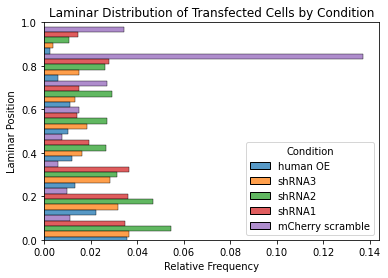

In [5]:
############
### plot these histograms with Seaborn
############

fig, ax = plt.subplots()
sns.histplot(data=fulldf,
             y = 'Norm_Flipped_Cells_Y_Pos',
             hue = 'Condition',
             stat = 'probability', #normalizes counts so that the sum of the bar heights is 1
             multiple = 'dodge',
             bins = 10)

ax.set_ylim([0, 1])
ax.set_ylabel('Laminar Position')
ax.set_xlabel('Relative Frequency')
ax.set_title('Laminar Distribution of Transfected Cells by Condition')
plt.show()

'mCherry scramble' is the control plasmid condition, here shown to differ from the other experimental conditions, which is consistent with visual inspection of microscopy results